Continuous-time model
---

Let's order the infection times $t_{\pi_{1}}<t_{\pi_{2}}<\dots<t_{\pi_{N}}$
. Let $\lambda_{i}\left(t\right)$ be a time-dependent transmission
rate and $L_{i}\left(t\right)=\int_{0}^{t}\lambda_{ij}\left(s\right)ds$
its primitive. Then $\rho_{i}\left(t_i; t_j\right)=\lambda_{i}\left(t_i\right)e^{-\int_{t_j}^{t_i}\lambda_{i}\left(s\right)ds} = \lambda_{i}\left(t_j\right)e^{L_{i}(t_j) - L_{i}(t_i) }$
will be the transmission ``delay'' density distribution. 

\begin{align*}p\left(t_{1},\dots,t_{N}\right) & =\prod_{i=1}^{N}\lim_{ds\to0^{+}}\frac{\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i}-ds)}-\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i})}}{ds}\\
 & =\prod_{i=1}^{N}\frac{d}{ds}_{|s=0}\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i}-ds)}\\
 & =\prod_{i=1}^{N}\left\{ \left(\prod_{j\in\partial i:t_{j}<t_{i}}e^{L_{i}(t_{j})-L_{i}(t_{i})}\right)\sum_{j\in\partial i:t_{j}<t_{i}}\lambda_{i}\left(t_{i}\right)\right\} \\
\mathcal{L}_{0}\left(t_{1},\dots,t_{N}\right) & =\log p\left(t_{1},\dots,t_{N}\right)\\
 & =-\sum_{i=1}^{N}\left\{ \sum_{j\in\partial i:t_{j}<t_{i}}\left(L_{i}(t_{i})-L_{i}(t_{j})\right)-\log\left(\sum_{j\in\partial i:t_{j}<t_{i}}\lambda_{i}\left(t_{i}\right)\right)\right\} 
\end{align*}

Note that $$\int_{t_j}^{t_i} \rho_{i}(s; t_j) ds = 1-e^{-\left(L_{i}(t_i) - L_{i}(t_j)\right)}$$ so $$\lambda_{i}(t) = -\frac{d}{dt}\log \left(1-\int_{t_j}^{t_i} \rho_{i}(s) ds\right)$$


\begin{align}\lambda(t) & =ae^{-\left(\frac{t-b}{c}\right)^{2}}\\
\frac{x-b}{c} & =\frac{y}{\sqrt{2}}\\
dx & =\frac{c}{\sqrt{2}}dy\\
L(t)=\int_{0}^{t}ae^{-\left(\frac{x-b}{c}\right)^{2}}dx & = ac\int_{\frac{0-b}{c}}^{\frac{t-b}{c}}e^{-y^{2}}dy\\
 & =ac\sqrt{\pi}\frac{1}{\sqrt{\pi}}\int_{-\frac{b}{c}}^{\frac{t-b}{c}}e^{-y^{2}}dy\\
 & =\frac{ac\sqrt{\pi}}{2}\left(\mathrm{erfc}\left(-\frac{t-b}{c}\right)-\mathrm{erfc}\left(\frac{b}{c}\right)\right)\\
\rho_{i}\left(t_{i};t_{j}\right) & =\lambda_{i}\left(t_{i}\right)e^{-\int_{t_{j}}^{t_{i}}\lambda_{i}\left(s\right)ds}=\lambda_{i}\left(t_{i}\right)e^{L_{i}(t_{j})-L_{i}(t_{i})}\\
\frac{d}{ds}-e^{L_{i}(t_{j})-L_{i}(s)} & =\lambda\left(s\right)e^{L_{i}(t_{j})-L_{i}(s)}=\rho_{i}\left(s;t_{j}\right)\\
\end{align}

Sampling 
---
\begin{align}
\int_{t_{j}}^{t}\rho(s;t_{j})ds & =1-e^{L_{i}(t_{j})-L_{i}(t)}=1-r\sim U(0,1)\\
e^{L_{i}(t_{j})-L_{i}(t)} & =r\\
L_{i}(t) & =L_{i}\left(t_{j}\right)-\log(r)\\
\mathrm{erfc}\left(-\frac{t-b}{c}\right) & =\frac{2}{ac\sqrt{\pi}}\left(L_{i}\left(t_{j}\right)-\log(r)\right)+\mathrm{erfc}\left(\frac{b}{c}\right)\\
t & =-c\,\mathrm{ierfc}\left(\frac{2}{ac\sqrt{\pi}}\left(L_{i}\left(t_{j}\right)-\log(r)\right)+\mathrm{erfc}\left(\frac{b}{c}\right)\right)+b
\end{align}

In [1]:
using PyCall
@pyimport sib
function sibyl(N, T_cont, Λ, O, γ, λ ; dt=1/5, maxit = 400, tol = 1e-14)
    
    T = Int(round(T_cont / dt))
    contacts = [(i-1,j-1,t, λ * dt) for t in 1:T for (i,j,v) in zip(findnz(Λ.A)...)];
    obs = [[(i,-1,t) for t=1:T for i=0:N-1];
           [(i-1,s,Int(round(t/dt))) for (i,s,t,p) in O]]
    sort!(obs, lt=((i1,s1,t1),(i2,s2,t2))->(t1<t2))
    prob_sus = 0.5
    prob_seed=γ
    pseed = prob_seed / (2 - prob_seed)
    psus = prob_sus * (1 - pseed)
    params = sib.Params(prob_r=sib.Exponential(mu=0), pseed=pseed, psus=psus,pautoinf=1e-10,fp_rate=1e-10,fn_rate=1e-10)
    f = sib.FactorGraph(contacts=contacts, observations=obs, params=params)
    sib.iterate(f, maxit=maxit,tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.5, tol=tol)
    sib.iterate(f, maxit=maxit, damping=0.9, tol=tol)
    p_sib=[collect(n.bt) for n in f.nodes]
    m_sib = zeros(N, T)
    for i=1:N
        m_sib[i,1] = p_sib[i][1] 
        for t=2:T
            m_sib[i,t] = m_sib[i,t-1] + p_sib[i][t]
        end
    end 
    return m_sib
end


sibyl (generic function with 1 method)

In [2]:
using SparseArrays, LinearAlgebra
using Causality

┌ Info: Precompiling Causality [943c2df0-3341-4665-8895-8aff0dd63d80]
└ @ Base loading.jl:1423
┌ Warning: Package CRlibm does not have Libdl in its dependencies:
│ - If you have CRlibm checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with CRlibm
└ Loading Libdl into CRlibm from project dependency, future warnings for CRlibm are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for IntervalArithmetic [d1acc4aa-44c8-5952-acd4-ba5d80a2a253]
│   exception = Required dependency CRlibm [96374032-68de-5a5b-8d9e-752f78720389] failed to load from a cache file.
└ @ Base loading.jl:1132
┌ Warning: Package CRlibm does not have Libdl in its dependencies:
│ - If you have CRlibm checked out for development and have
│   added Libdl as a dependency but haven't updated your primary
│   environment's manifes

In [5]:
T, N = 20.0, 1000
#G = Causality.makeBarabasi(N,k=2)
#ρ = 3/N
#G = Causality.makeGNP(N,ρ)
G = Causality.makeProximity(N,3/N)
G.A 

1000×1000 SparseMatrixCSC{IndexedGraphs.NullNumber, Int64} with 8890 stored entries:
⢔⣱⢾⣧⢧⡼⡖⣻⣂⢿⢹⣷⣧⣮⡾⡶⣳⡿⣿⣿⣿⣤⢶⢷⣷⢲⢶⣕⣾⣯⣗⣶⡵⣲⣯⠾⢢⣳⢷⣷
⠾⣷⡏⣭⠷⢽⢛⢿⣻⣭⡯⡿⠷⣗⣿⢾⡿⢯⣟⢶⣍⠞⣗⢻⠾⡿⣇⢦⢿⣮⡷⣽⣷⣵⡟⣿⢶⣕⡻⣿
⣉⡷⣝⣇⣎⢙⢿⣛⣿⡅⣧⣿⡛⡽⢿⣿⣿⣻⣷⢷⠝⡿⠓⣒⣙⣕⡸⡾⣾⢿⡸⢧⠞⢙⡿⣟⠻⡛⠺⢗
⣼⣩⣿⣔⣿⢳⣟⢝⢳⢍⣍⣶⣧⡯⣟⣕⢾⣓⢮⢾⢣⢯⣹⣿⠗⣿⢽⡯⢎⣔⢭⡿⢯⡯⢭⣯⢿⣛⣯⡕
⣬⣜⡟⣾⠟⠿⡝⢖⣾⣿⣟⢿⣷⣖⣿⡿⢾⣻⣷⣾⣯⠬⣷⣷⣫⣗⣿⣧⡬⣻⣡⣆⣿⣻⣽⣻⢫⣷⡽⣏
⢷⣶⣯⡯⣭⣿⢣⣽⣿⣝⣔⡹⣿⣱⡾⣧⣭⣻⣿⣼⡏⣯⡾⣒⣵⣺⡾⢏⡿⣵⡶⣽⡿⣮⠫⡻⣾⣭⠯⣋
⡩⣿⢽⢧⣟⡬⡭⡿⢹⢿⢟⣻⣮⡻⣮⡿⣮⣿⣽⡷⣿⣾⣻⣿⡳⣕⣯⣿⣻⣟⣽⣵⣼⡏⣮⣜⣞⣺⡓⡓
⢺⡯⣻⣟⣿⣷⢟⢽⣿⡿⠾⣯⣮⡿⢪⣲⣂⢷⢞⠻⢯⡯⣿⣳⣿⡯⣭⣯⢛⣼⢿⡙⣿⣷⣾⣮⣸⣺⣿⣵
⣽⡾⡿⣏⣿⣻⢾⢳⣾⣳⣧⣻⣮⣿⢬⣜⣿⠛⣿⡾⣷⡷⢇⣿⣚⡦⢧⣷⢿⣦⡞⢮⢵⣽⡿⣭⣽⡝⣯⣶
⣿⣿⢻⣝⢽⣟⣪⣗⣹⣿⣛⣿⢷⡿⣾⡑⣻⡿⡾⢋⢽⣽⣃⣿⣋⡟⢽⣿⢿⣿⡕⡿⡲⣭⣽⣶⡲⣎⣯⡉
⠛⣿⣣⠝⣷⡥⡭⣖⡋⡟⡯⣭⣻⣿⡯⡷⢽⡿⣗⣷⣾⣿⣿⢃⣿⢸⣃⠿⣧⡽⣥⣟⣉⢛⣧⢛⡶⢻⣏⣻
⢼⣗⣽⣙⢹⢠⣷⣾⢽⣿⢺⢫⣿⣾⢿⣻⣭⣵⣭⣼⠿⢛⢫⡶⣺⣟⢕⡷⣣⢷⡿⣹⣤⣷⠿⡭⡽⢻⢲⣇
⢹⣛⣾⡧⢗⢼⣽⣥⢯⢾⣱⣻⢝⢮⡿⡿⠺⡼⣯⠼⣛⣛⣾⢾⣟⡽⣿⣯⣚⣽⣣⢯⣭⣟⡋⣤⣭⣷⣞⣽
⢜⢷⠩⣝⣲⡮⡷⡷⠿⣿⡾⢏⣯⣿⡧⣿⢭⣷⣷⣷⣭⡜⢵⡵⡿⣿⣾⡻⡾⣛⢷⡮⣿⣷⡮⣿⣳⣗⠽⢓
⡾⣿⡻⣷⣾⣟⢊⢵⣦⣫⢟⣯⣿⢾⣛⣴⠻⣷⣿⣷⣍⡿⢭⣞⣞⣼⣾⢫⢅⢕⢻⠻⢽⡷⡞⣷⢾⣿⣚⡆
⢹⣽⣝⣯⠶⣎⣧⡷⠡⢾⣜⣯⢗⣿⣟⠳⡺⣍⣵⡭⣥⢿⣟⣫⡭⣞⡹⡷⣿⡒⡿⡯⣼⠼⣻⣾⣛⢅⣇⣧
⢱⣫⢝⣿⣞⢁⡯⡷⣿⣻⡻⣯⡶⠿⢿⣿⣕⣷⡜⣮⣧⢘⢤⣿⣧⢿⢿⣿⢷⡷⣒⡟⢯⠗⣫⣴⣿⢿⣞⣗
⣫⡟⣿⣭⣿⢯⡧⣷⣷⣻⣯⡢⣊⢿⡺⣿⡟⣯⢳⣿⣭⢛⡟⡧⠋⣬⣮⣯⢾⣭⣻⣾⢋⣾⡰⣪⣟⢟⢛⡆
⢬⣲⢜⢷⣿⠢⣿⢳⢯⣶⡞⣿⣺⣹⣲⣺⣗⠿⡸⢮⣼⣋⣷⣋⢧⣿⢽⢾⣾⣷⠟⢜⣿⣟⣿⢝⣫⡺⣾⠩
⢽⣷⣿⣮⢾⢆⢏⠿⡷⢯⡯⢣⢽⠨⢟⣿⢫⣿⡏⠻⣯⣹⠼⢶⣞⣽⢷⢃⠺⠼⠭⣽⢾⢽⠻⠴⡞⡛⣏⡹

In [6]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [7]:
#Initialize generation parameters
ε = 1e-10
λ = 0.2
pseed = 1/N
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
inf_out = GaussianRate(λ, T/2, 1/ε)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [8]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [9]:
struct MaskedInferentialSI <: SI end

Causality.individual(M::StochasticModel{MaskedInferentialSI}, i::Int, θi = @view(M.θ[:,i]), θg = M.θgen ) = 
@views IndividualSI(θi[1], 
    MaskedRate(GaussianRate(θi[2:4]...),mask[i]), 
    MaskedRate(GaussianRate(θi[5:7]...),mask[i]), 
    GaussianRate(θg[5:7]...))

In [10]:
const Ig = GenerativeSI{GaussianRate,GaussianRate} 
const Ii = GaussianInferentialSI

GaussianInferentialSI

In [11]:
Mp = StochasticModel(Ig, T, θp, G, θpgen);
sample! = Sampler(Mp);

xtrue = zeros(N)
sample!(xtrue)
nobs, p = Int(round(N/10)), 1e-5
#nobs, p = N, 1e-5
O = [(ti = T*(1+rand())/2; (i,xtrue[i] < ti,ti,p)) for i=1:nobs]
sum(xtrue .< T)

772

In [12]:
O

100-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 17.075968910883546, 1.0e-5)
 (2, 1, 19.724931315899294, 1.0e-5)
 (3, 0, 18.1613097628383, 1.0e-5)
 (4, 0, 12.608056693575303, 1.0e-5)
 (5, 1, 17.097886856248756, 1.0e-5)
 (6, 1, 14.2066053048433, 1.0e-5)
 (7, 1, 10.320158675779258, 1.0e-5)
 (8, 1, 16.14853888140616, 1.0e-5)
 (9, 0, 14.939856454349755, 1.0e-5)
 (10, 0, 17.165093786049198, 1.0e-5)
 (11, 0, 16.431507617946735, 1.0e-5)
 (12, 0, 15.764671008550259, 1.0e-5)
 (13, 1, 10.319089107736739, 1.0e-5)
 ⋮
 (89, 0, 14.199579906004098, 1.0e-5)
 (90, 1, 17.65251361222012, 1.0e-5)
 (91, 1, 16.714834419544943, 1.0e-5)
 (92, 1, 13.057038321910571, 1.0e-5)
 (93, 0, 15.518908169935477, 1.0e-5)
 (94, 0, 11.298978687463155, 1.0e-5)
 (95, 1, 13.953883187124795, 1.0e-5)
 (96, 1, 18.647968406894236, 1.0e-5)
 (97, 1, 19.04604729475771, 1.0e-5)
 (98, 0, 10.984389958153491, 1.0e-5)
 (99, 1, 17.7699242137416, 1.0e-5)
 (100, 0, 16.174970664858485, 1.0e-5)

In [13]:
#Softened model
T = Float64(T)
ε = 2e-3
autoinf = GaussianRate(ε, T/2, T);
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T );

θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Ig, T, θp2, G, θp2gen);

In [14]:
using IntervalUnionArithmetic
T = Float64(T)
mask = fill(IntervalUnion(0., T),N)
for o in O
    if o[2] == 1 
        mask[o[1]] = mask[o[1]] ∩ IntervalUnion(0., o[3])
    elseif o[2] == 0
        mask[o[1]] = mask[o[1]] ∩ IntervalUnion(o[3], T)
    end
end

In [15]:
θ = getpar(pseed, autoinf, inf_in);
M = StochasticModel(MaskedInferentialSI, T, θ, G, θp2gen);

In [16]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, O; M=M, numsamples=1000, numiters=100, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.),learnhyper=1);
F

Progress: 100%|█████████████████████████████████████████| Time: 0:07:01
  F:  1100.76943423112


1100.76943423112

In [17]:
statscau = prior(M, numsamples=5000);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [22]:
a=time()
dt = 1/4
p_sib = sibyl(N, T, G, O, 1/N, λ; dt=dt, maxit = 40, tol = 1e-7);
b=time()
println(b-a)

sib.iterate(damp=0.0): 39/40 2.758e-01/1e-07      
sib.iterate(damp=0.5): 39/40 6.006e-02/1e-07      
344.73148989677430.9): 39/40 1.023e-01/1e-07      


## Marginals and ROC curve

In [18]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

AUROC (generic function with 1 method)

In [19]:
O

100-element Vector{Tuple{Int64, Bool, Float64, Float64}}:
 (1, 0, 17.075968910883546, 1.0e-5)
 (2, 1, 19.724931315899294, 1.0e-5)
 (3, 0, 18.1613097628383, 1.0e-5)
 (4, 0, 12.608056693575303, 1.0e-5)
 (5, 1, 17.097886856248756, 1.0e-5)
 (6, 1, 14.2066053048433, 1.0e-5)
 (7, 1, 10.320158675779258, 1.0e-5)
 (8, 1, 16.14853888140616, 1.0e-5)
 (9, 0, 14.939856454349755, 1.0e-5)
 (10, 0, 17.165093786049198, 1.0e-5)
 (11, 0, 16.431507617946735, 1.0e-5)
 (12, 0, 15.764671008550259, 1.0e-5)
 (13, 1, 10.319089107736739, 1.0e-5)
 ⋮
 (89, 0, 14.199579906004098, 1.0e-5)
 (90, 1, 17.65251361222012, 1.0e-5)
 (91, 1, 16.714834419544943, 1.0e-5)
 (92, 1, 13.057038321910571, 1.0e-5)
 (93, 0, 15.518908169935477, 1.0e-5)
 (94, 0, 11.298978687463155, 1.0e-5)
 (95, 1, 13.953883187124795, 1.0e-5)
 (96, 1, 18.647968406894236, 1.0e-5)
 (97, 1, 19.04604729475771, 1.0e-5)
 (98, 0, 10.984389958153491, 1.0e-5)
 (99, 1, 17.7699242137416, 1.0e-5)
 (100, 0, 16.174970664858485, 1.0e-5)

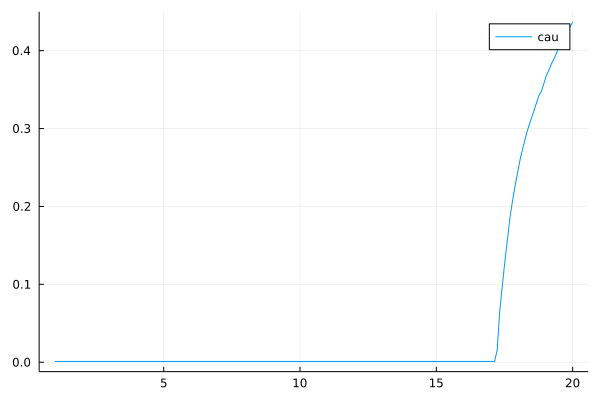

In [21]:
#Marginals
bins = 10 * Int(T)
using Plots
p_cau = zeros(N,bins)
for i = 1:N
    for t = 1:bins
       p_cau[i,t] = marginal(i, t*T/bins, statscau)
    end
end
i = 1
plot(LinRange(1,Int(T),bins),p_cau[i,:], label = "cau")
#plot!(LinRange(1,Int(T),Int(round(T/dt))),p_sib[i,:], label = "sib")

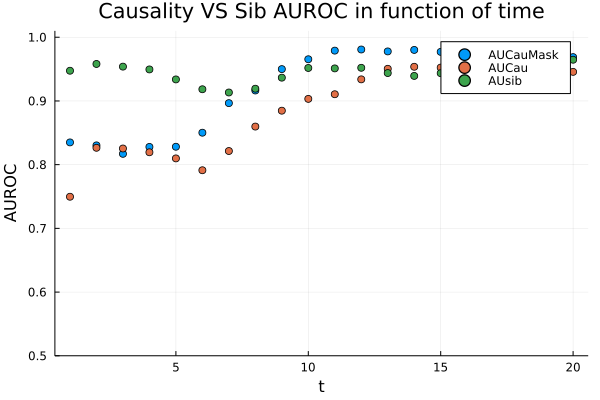

In [95]:
#AUROC curves

T = Int(T)
AU_curve2=zeros(T)
AU_sib=zeros(T)
for t = 1:T
    cau_risk=zeros(N)
    sib_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t,statscau)
       sib_risk[i] = p_sib[i,Int(round(t/dt))] 
    end
    xt = xtrue .< t
    AU_curve2[t] = AUROC(ROC(xt, cau_risk))
    #AU_fast[t]  = AUROC(ROC(xt, fast_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
end

scatter(LinRange(1,T,T),AU_curve, label="AUCauMask", title="Causality VS Sib AUROC in function of time")
scatter!(LinRange(1,T,T),AU_curve2, label="AUCau", title="Causality VS Sib AUROC in function of time")
scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
#plot!(LinRange(1,T,T), AU_fast, label="AUN2")
xlabel!("t")
ylabel!("AUROC")
#savefig("confronti.pdf")
ylims!(0.5,1.01)

In [170]:
AU_sib

20-element Vector{Float64}:
 0.9347368421052631
 0.9483695652173914
 0.9678030303030304
 0.969053934571176
 0.9667774086378738
 0.966690290574061
 0.9579945799457994
 0.9668474984930682
 0.9662447257383966
 0.9731934731934732
 0.9734613212874083
 0.9676535087719298
 0.972972972972973
 0.9914285714285714
 0.9976624590930341
 0.9957924263674613
 0.9955436720142603
 0.9770797962648559
 0.9768499379909054
 0.9412484700122401